# Imports

In [10]:
import numpy as np
import scipy
import pandas as pd
import requests
from os import makedirs, path, listdir, remove
from bs4 import BeautifulSoup, SoupStrainer
import zipfile as zpf
from shutil import rmtree
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize
import matplotlib
from matplotlib import cm
from datetime import datetime
import seaborn as sns
import httplib2
import geopandas as gpd
from tqdm import tqdm
from typing import Tuple, List, Optional, Union

from graph_utils import *


## Load LAQN Data

In [59]:
def load_data(species, region, start_date, end_date, data_folder):
    data_filename = f"LAQN_{species}_{start_date}_{end_date}.csv"
    file_path = path.join(data_folder, data_filename)

    # Load LAQN data
    laqn_df = pd.read_csv(file_path, index_col="date", infer_datetime_format=True)
    # Drop the 'date' column
    laqn_df = laqn_df.drop(columns=['date']) if 'date' in laqn_df.columns else laqn_df

    return laqn_df

In [60]:
region = "London"
start_date = "1996-01-01"
end_date = "2021-01-01"
data_folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code"

In [61]:
species = "NO2"
no2_df = load_data(species, region, start_date, end_date, data_folder)
print(no2_df.shape)

(219169, 201)


In [62]:
species = "PM10"
pm10_df = load_data(species, region, start_date, end_date, data_folder)
print(pm10_df.shape)

(219169, 174)


# Quantify missing data

In [90]:
species = "PM10"

In [91]:
laqn_df = no2_df if species == "NO2" else pm10_df if species == "PM10" else None

# Make sure the 'date' column is in datetime format
# laqn_df['date'] = pd.to_datetime(laqn_df.index)

# Create a DataFrame to store the start and end dates for each station
station_dates = pd.DataFrame(index=laqn_df.columns, columns=['start_date', 'end_date'])

# Iterate over each station to find the start and end dates
for station in laqn_df.columns:
    # Find the first non-NaN date for the station
    start_date = laqn_df[station].first_valid_index()
    
    # Find the last non-NaN date for the station
    end_date = laqn_df[station].last_valid_index()
    
    # Store the start and end dates in the station_dates DataFrame
    station_dates.at[station, 'start_date'] = start_date
    station_dates.at[station, 'end_date'] = end_date

# Create two masks for each station based on the start and end dates
mask_include_nan = pd.DataFrame(index=laqn_df.index, columns=laqn_df.columns, dtype=bool)
mask_exclude_nan = pd.DataFrame(index=laqn_df.index, columns=laqn_df.columns, dtype=bool)

for station in laqn_df.columns:
    start_date = station_dates.at[station, 'start_date']
    end_date = station_dates.at[station, 'end_date']
    
    # Set True for the period between start and end dates, including NaN values
    mask_include_nan[station] = (laqn_df.index >= start_date) & (laqn_df.index <= end_date)
    
    # Set True for the period between start and end dates, excluding NaN values
    mask_exclude_nan[station] = (laqn_df.index >= start_date) & (laqn_df.index <= end_date) & laqn_df[station].notna()


# Count the number of datapoints using the masks for commissioning period
count_include_nan = mask_include_nan.sum().sum()
count_exclude_nan = mask_exclude_nan.sum().sum()

# Display the results
print("Count including NaN values:", count_include_nan)
print("Count excluding NaN values:", count_exclude_nan)
print("Percentage of non-NaN values:", (count_exclude_nan / count_include_nan) * 100)

# Calculate the number of non-NaN datapoints for each station using the masks
per_station_count_include_nan = mask_include_nan.sum()
per_station_count_exclude_nan = mask_exclude_nan.sum()

# Calculate the percentage of non-NaN values for each station
percentage_per_station = (per_station_count_exclude_nan / per_station_count_include_nan) * 100

# Set index as the station names
percentage_per_station.index.name = 'Station'

percentage_per_station = percentage_per_station.sort_values(ascending=False)

# # Display the results
# print("Percentage of non-NaN values per station:")
# print(percentage_per_station)


Count including NaN values: 15444892
Count excluding NaN values: 13288835
Percentage of non-NaN values: 86.04032323437418


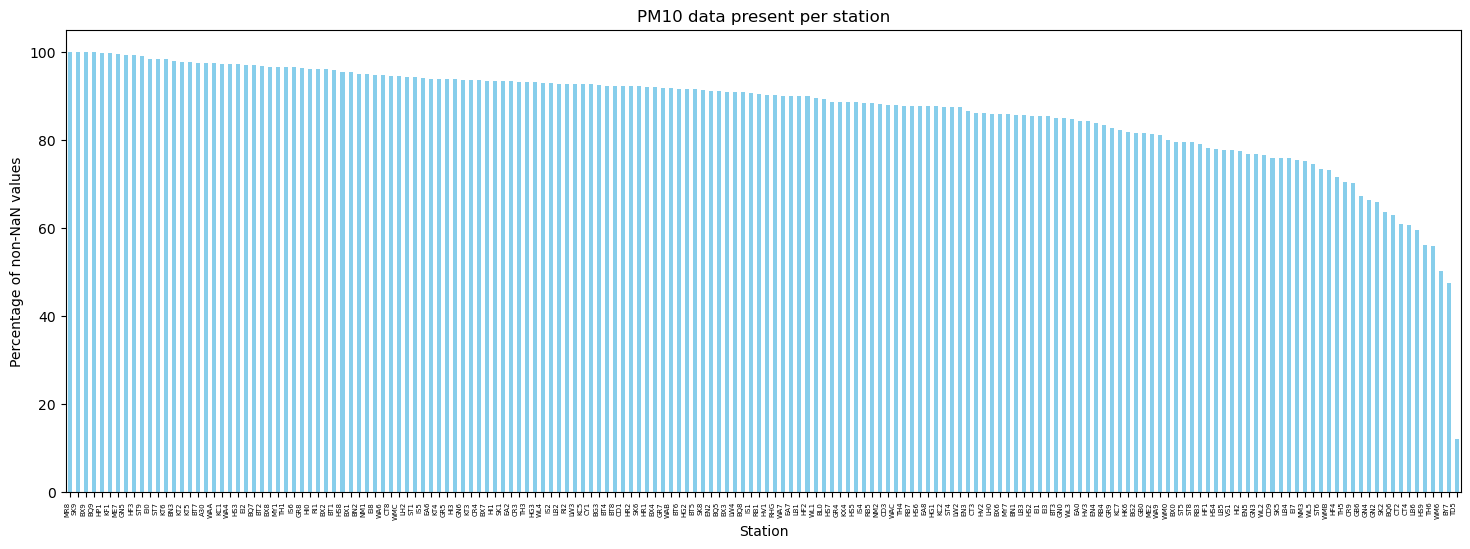

In [92]:
# Plot the bar chart
ax = percentage_per_station.plot(kind='bar', figsize=(18, 6), color='skyblue')
ax.set_ylabel('Percentage of non-NaN values')
ax.set_title(f'{species} data present per station')

# Rotate x-axis labels for better readability
# plt.xticks(rotation=90, ha='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=5)

# Show the plot
plt.show()

In [93]:
# Create a DataFrame to store the missing data periods for each station
missing_data_periods = pd.DataFrame(index=laqn_df.columns, columns=['missing_periods'])

# Iterate over each station
for station in laqn_df.columns:
    start_date = station_dates.at[station, 'start_date']
    end_date = station_dates.at[station, 'end_date']
    
    # Filter the NaN values within the commissioning period
    missing_data_mask = (laqn_df.index >= start_date) & (laqn_df.index <= end_date) & laqn_df[station].isna()
    
    # Identify the start and end dates of each missing data period
    missing_periods = missing_data_mask.groupby((missing_data_mask != missing_data_mask.shift()).cumsum()).apply(
        lambda x: (x.index[0], x.index[-1]) if x.all() else None
    ).dropna()
    
    # Store the missing data periods for each station
    missing_data_periods.at[station, 'missing_periods'] = missing_periods.tolist() if not missing_periods.empty else []

# Display the results
# print("Missing data periods per station:")
# print(missing_data_periods)


In [94]:
# Convert the dates to datetime format
missing_data_periods['missing_periods'] = missing_data_periods['missing_periods'].apply(lambda x: [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in x])

# Calculate the longest missing data period and corresponding station
missing_data_periods['longest_missing_period'] = missing_data_periods['missing_periods'].apply(lambda x: max([(end - start) for start, end in x], default=pd.Timedelta(0)))
station_with_longest_period = missing_data_periods.loc[missing_data_periods['longest_missing_period'].idxmax()]

# Calculate the average length of missing data periods
missing_data_periods['average_missing_period'] = missing_data_periods['missing_periods'].apply(lambda x: sum([(end - start) for start, end in x], start=pd.Timedelta(0)) / len(x) if len(x) > 0 else pd.Timedelta(0))
average_length_of_missing_data = missing_data_periods['average_missing_period'].mean()

# Print the results
print(f"{species} station with the longest missing data period:")
print(station_with_longest_period.name, station_with_longest_period["longest_missing_period"])

print("\nAverage length of missing data periods:")
print(average_length_of_missing_data)


PM10 station with the longest missing data period:
BY7 3474 days 14:00:00

Average length of missing data periods:
2 days 06:18:36.496449283


# Comparisons between NO2 and PM10

In [95]:
print(no2_df.shape)
print(pm10_df.shape)

(219169, 201)
(219169, 174)


In [96]:
# Step 1: Identify common stations
common_stations = set(no2_df.columns) & set(pm10_df.columns)
num_common_stations = len(common_stations)

# Step 2: Create an empty dataframe for the correlation results
correlation_results = pd.DataFrame(columns=['Station', 'Correlation'])

# Step 3: Iterate over common stations and calculate correlation
for station_code in common_stations:
    no2_station = no2_df[station_code]
    pm10_station = pm10_df[station_code]

    # Create a merged dataframe for the specific station
    merged_station_df = pd.concat([no2_station, pm10_station], axis=1, keys=['NO2', 'PM10'])

    # Drop rows with missing values
    merged_station_df = merged_station_df.dropna()

    # Calculate correlation
    correlation = merged_station_df.corr().iloc[0, 1]

    # Append results to the correlation dataframe
    correlation_results = correlation_results.append({'Station': station_code, 'Correlation': correlation}, ignore_index=True)

# Step 4: Sort the dataframe by correlation in descending order
correlation_results = correlation_results.sort_values(by='Correlation', ascending=False)


In [101]:
print("Mean correlation between NO2 and PM10:", correlation_results['Correlation'].mean())

Average correlation between NO2 and PM10: 0.5026370461078407


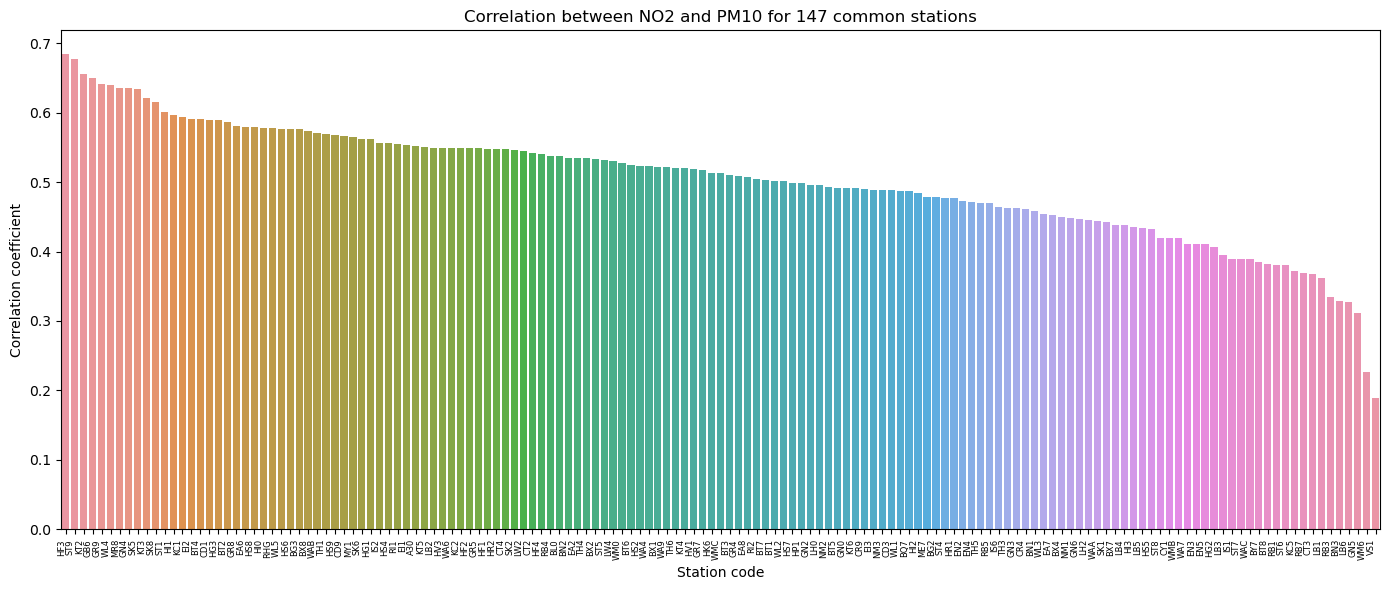

In [97]:
# Step 5: Plot the correlation results
plt.figure(figsize=(14, 6))
ax = sns.barplot(x='Station', y='Correlation', data=correlation_results)

# Adjust x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=6)

plt.title(f'Correlation between NO2 and PM10 for {num_common_stations} common stations')
plt.xlabel('Station code')
plt.ylabel('Correlation coefficient')
plt.tight_layout()
plt.show()

In [98]:
def plot_correlation_for_station(station_code, no2_df, pm10_df):
    # Step 1: Extract data for one station
    no2_station = no2_df[station_code]
    pm10_station = pm10_df[station_code]

    # Step 2: Create a merged dataframe for the specific station
    merged_station_df = pd.concat([no2_station, pm10_station], axis=1, keys=['NO2', 'PM10'])

    # Step 3: Drop rows with missing values
    merged_station_df = merged_station_df.dropna()

    # Step 4: Calculate correlation
    correlation = merged_station_df.corr().iloc[0, 1]

    # Step 5: Plot the data
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='NO2', y='PM10', data=merged_station_df)
    plt.title(f'Correlation for Station {station_code}: {correlation:.2f}')
    plt.xlabel('NO2 Concentration')
    plt.ylabel('PM10 Concentration')
    plt.show()


Station with the highest correlation:


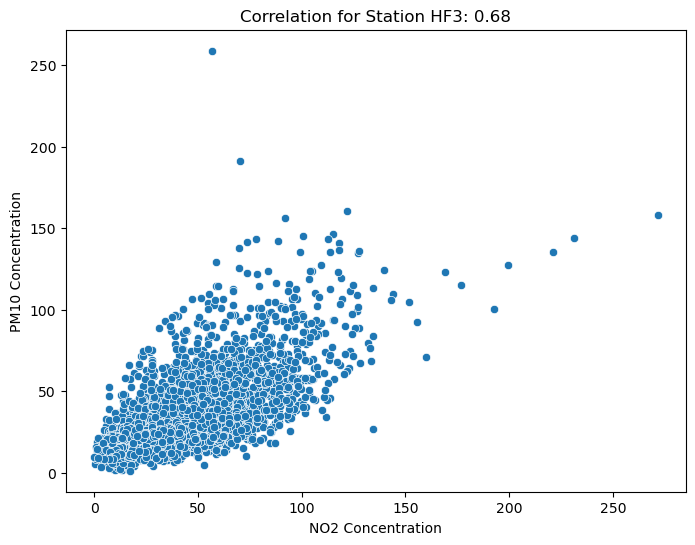

Station with the lowest correlation:


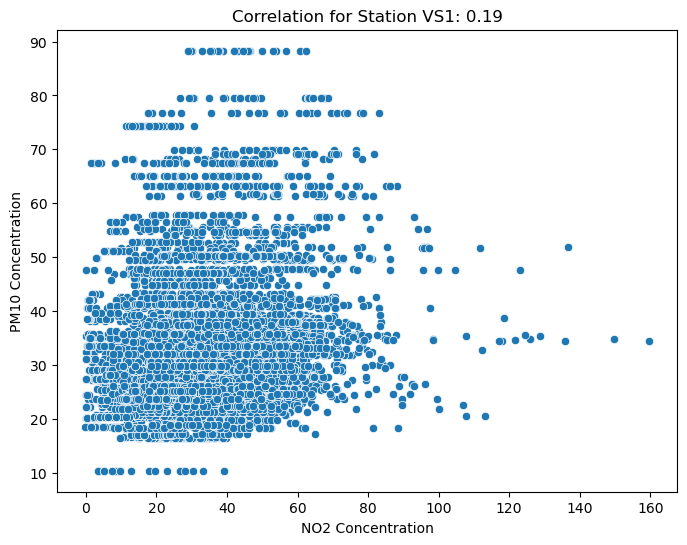

In [99]:
print("Station with the highest correlation:")
station = correlation_results.head(1)['Station'].values[0]
plot_correlation_for_station(station, no2_df, pm10_df)

print("Station with the lowest correlation:")
station= correlation_results.tail(1)['Station'].values[0]
plot_correlation_for_station(station, no2_df, pm10_df)

# Map plots

(33, 10)


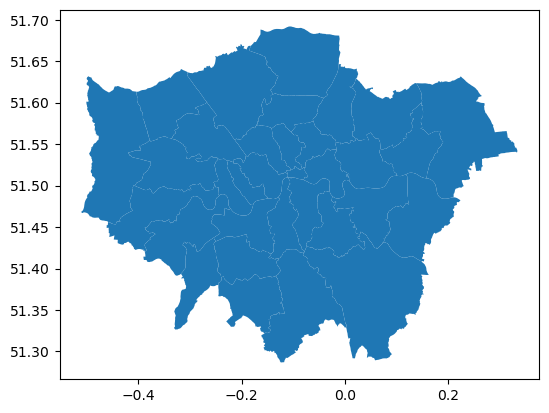

In [ ]:
# Load map file
folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code/Andrea_data/shape_files/london_boroughs"
london_boroughs_gdf = gpd.read_file(path.join(folder, "london_boroughs_coordinates.shp"))
#london_gdf = london_boroughs_gdf.dissolve()
print(london_boroughs_gdf.shape)
london_boroughs_gdf.plot()
plt.show()

In [ ]:
# Load LAQN metadata
folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code/Andrea_data/shape_files/LAQN_sites"
london_sites_gdf = gpd.read_file(path.join(folder, "LAQN_sites.shp"))
print(london_sites_gdf.shape)
# london_sites_gdf.plot()
# plt.show() 
print(london_sites_gdf.head())

(248, 17)
  @LocalAuth            @LocalAu_1 @SiteCode  \
0         27              Richmond       TD0   
1          1  Barking and Dagenham       BG3   
2          1  Barking and Dagenham       BG1   
3          1  Barking and Dagenham       BG2   
4          2                Barnet       BN2   

                                    @SiteName         @SiteType  \
0  - National Physical Laboratory, Teddington          Suburban   
1         Barking and Dagenham - North Street          Kerbside   
2           Barking and Dagenham - Rush Green          Suburban   
3       Barking and Dagenham - Scrattons Farm          Suburban   
4                           Barnet - Finchley  Urban Background   

            @DateClose           @DateOpene         @Latitude  \
0  2018-01-01 00:00:00  1996-08-08 00:00:00  51.4243043441456   
1  2011-05-25 00:00:00  2007-03-16 00:00:00         51.540444   
2                 None  1999-11-02 00:00:00         51.563752   
3                 None  1999-10-17 00: